# Projeto de classificação de digitos a mão

## Importação das bibliotecas

In [3]:
import torch 
import torch.nn as nn # Montas as redes neurais
from torch import optim # optimizador
import torch.nn.functional as F # Função de ativação da rede
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms # Transformar as imagens em formato de tensor

## Importação da base de dados

In [52]:
torch.manual_seed(123) # Semente no CPU

In [53]:
transform = transforms.ToTensor()

In [54]:
# root -> caminho
# train -> Se é dados de treino ou teste
# Download para baixar
# Transform -> Transformar em tipo Tensor
X_train = datasets.MNIST(root='', train=True, download=True, transform=transform)
X_test = datasets.MNIST(root='', train=False, download=True, transform=transform)

In [55]:
X_train.data.shape

torch.Size([60000, 28, 28])

In [56]:
X_train.targets # Rotulos de cada imagem

tensor([5, 0, 4,  ..., 5, 6, 8])

In [57]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=128)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=128)

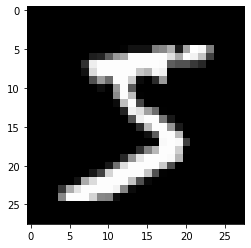

In [58]:
# Exibindo as imagens 
# View -> Como queremos retornar a imagem no caso o tamanho
img = next(iter(train_loader))[0][0].view(28,28) # Paramatros view 1 bat 2 canais 3 dimensao28,28
plt.imshow(img, cmap='gray')

(array([639.,  11.,   6.,  11.,   6.,   9.,  11.,  12.,  11.,  68.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

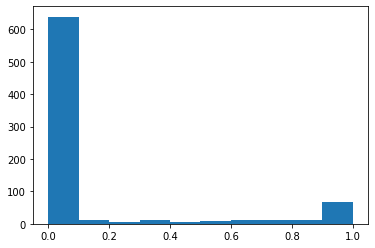

In [18]:
# Recuperar valor da img pois ele está em tensor por isso utiliza view
plt.hist(img.view(-1))

## Construção da rede CNN

In [33]:
class model_cnn(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Output = (input - filter + 1) / stride
        # Convulução 1: (28 - 3 + 1) / 1 = 26x26
        # Polling 1 13x13 valor 2 
        # Convolução 2: (13 - 3 + 1) / 1 = 11 = 10 # 10x10 pois não temos o valor de borda
        # Polling 2: 5x5 valor 2
        # in_channels -> canais da imagem 1 pois é preto e branco
        # out_channels -> Filtros que vao ser utilizados
        # Kernel_size é o filtro 3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(32, 32, (3,3))
        self.activation = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(num_features=32)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.flatten = nn.Flatten() # Achatar os dados em um array
        # Processo acima é chamado de achatamento
        
        # Definir a camada Densa
        self.linear1 = nn.Linear(in_features=32 * 5 * 5, out_features=128)
        self.linear2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)  # Evita overfiting zerando os valores do neurônios aleatóriamente %
        
    def forward(self, X):
        # Convolução e achatamento Filters MAP transforma 32 features map em 5x5
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))
        X = self.flatten(X)
        
        # Camada Densa Neurônios
        X = self.dropout(self.activation(self.linear1(X)))
        X = self.dropout(self.activation(self.linear2(X)))
        X = self.output(X)        
        
        return X

In [34]:
cnn_net = model_cnn()

In [35]:
cnn_net

model_cnn(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [36]:
criterion = nn.CrossEntropyLoss()

In [37]:
optimizer = optim.Adam(cnn_net.parameters())

## Treinamento da rede

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'gpu'
device

'cuda'

In [39]:
cnn_net.to(device)

model_cnn(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [191]:
def training_loop(loader, epoch):
    running_loss = 0. # Erro corrente da epoca
    running_accur = 0.
    for i,data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad # Zero o gradiente
        
        outputs = cnn_net(inputs)
        
        loss = criterion(outputs, labels) # Função de perda
        
        loss.backward() # Repropragar os erros para corrigir os pesos
        optimizer.step() 
        
        running_loss += loss.item() # retorna o valor 
        
        ps = F.softmax(outputs) # Probabilidade de cada classe retorna uma tabela com probabilidade de cada classe
        
        # k maior valor
        # Dimensão 
        top_p, top_class = ps.topk(k=1, dim=1) 
        equals = top_class == labels.view(*top_class.shape) # O * é o cast do valor para comparar
        
        accuracy = torch.mean(equals.type(torch.float))
        
        running_accur += accuracy
    print('\rÉpoch{:3d} Finalizada: perda {:.5f} - acurácia: {:.5f}'.format(epoch+1, 
                                                                            running_loss/len(loader), 
                                                                            running_accur/len(loader)))       

In [196]:
len(train_loader)

469

In [197]:
for epoch in range(5):
    print('Treinando...')
    training_loop(train_loader, epoch)
    cnn_net.eval()
    print('Validando...')
    training_loop(test_loader, epoch)
    cnn_net.train()

Treinando...


D:\Desenvolvimento\Anaconda\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Época   1 Finalizada: perda 2.34990 - acurácia 0.10219
Validando...
Época   1 Finalizada: perda 2.34760 - acurácia 0.10127
Treinando...


KeyboardInterrupt: 

## Avaliação da rede

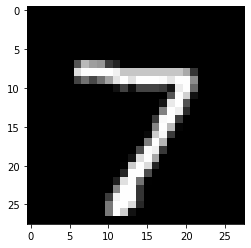

In [65]:
sample_img = next(iter(test_loader))[0][0].view(28,28)
plt.imshow(sample_img, cmap='gray');

In [175]:
sample_img = sample_img.view(1, 1, 28,28) # Batch canal da cor e tamanho

In [176]:
sample_img.shape

torch.Size([1, 1, 28, 28])

In [177]:
cnn_net.eval()

model_cnn(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [178]:
sample_img = sample_img.to(device)

In [179]:
type(sample_img)

torch.Tensor

In [180]:
output = cnn_net.forward(sample_img)

In [181]:
output = F.softmax(output)

D:\Desenvolvimento\Anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [182]:
output

tensor([[0.0742, 0.1632, 0.1265, 0.0631, 0.0665, 0.0892, 0.1354, 0.1241, 0.0894,
         0.0684]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [183]:
output = output.cpu().detach().numpy() # Tira do formato de gpu para cpu em numpy


In [184]:
resultado = np.argmax(output)

In [185]:
resultado

1

# Atividade Prática

No exemplo anterior foi utilizada a base de dados MNIST para classificação de dígitos escritos a mão. Além dela, outra base de dados bastante famosa é a CIFAR-10, que é utilizada para classificação de 10 classes, ou seja: avião, automóvel, pássaro, gato, veado, cachorro, sapo, cavalo, navio e caminhão. Clicando no link abaixo você pode ver mais detalhes sobre ela

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

Utilizando esta base de dados, o objetivo é construir uma rede neural conforme desenvolvemos no exemplo sobre o MNIST. 


Siga as seguintes dicas para concluir esta tarefa:

* Consulte a documentação do PyTorch para aprender como carregar essa base de dados. Acesse o link para mais detalhes 

> [Instrução para importar a base CIFAR-10](https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=cifar#torchvision.datasets.CIFAR10)


*  A dimensão das imagens é 32 x 32 e elas são coloridas (3 canais), portanto, você deve fazer esses ajustes no código fonte da rede CNN utilizada no exemplo anterior. 


* Sugestão primeira camada de convolução:


> `self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3))`

Enviar por e-mail o código desenvolvido: matheus.novaes@uel.br


In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets 
import torchvision.transforms as transforms

In [2]:
transform = transforms.ToTensor()

In [3]:
X_train = datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
X_test = datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=128)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=128)

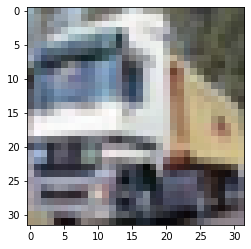

In [5]:
# View -> Batch quantidade de amostra dentro do tensor
images, labels = next(iter(train_loader))
#print(images.size())
images = images.permute(0,2,3,1).numpy()
plt.imshow(images[1])

In [6]:
class model_cnn(nn.Module):
    
    def __init__(self):
        super().__init__() 
        #output =(input -filter + 1)/stride
        #convulação (32 - 3 +1)/1 = 30x30
        #pooling 1: 15x15
        #convulação 2: (15 - 3 + 1)/ 1 = 11 = 13x13
        #pooling 2: 5x5
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.activation = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(num_features=32)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()

        #definir a camada densa
        self.linear1 = nn.Linear(in_features=32*6*6, out_features=128)
        self.linear2 = nn.Linear(128,128)
        self.linear3 = nn.Linear(128,128)
        self.output = nn.Linear(128,10)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, X):
        #primeira camada de convolução
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))
        X = self.flatten(X)
        #camada densa
        X = self.dropout((self.activation(self.linear1(X))))
        X = self.dropout((self.activation(self.linear2(X))))
        X = self.dropout((self.activation(self.linear3(X))))
        X = self.output(X)
        return X

In [7]:
cnn_net = model_cnn()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_net.parameters())

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
cnn_net.to(device)

model_cnn(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=1152, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [11]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accu = 0.
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = cnn_net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k=1,dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        accuracy = torch.mean(equals.type(torch.float))
        
        running_accu += accuracy 
        
    print('\rÉpoca {:3d} Finalizada: perda {:.5f} - acurácia {:.5f}'.format(epoch+1, 
                                                            running_loss/len(loader),
                                                            running_accu/len(loader)))
        

In [12]:
len(train_loader)

391

In [13]:
for epoch in range(2):
    print('Treinando...')
    training_loop(train_loader, epoch)
    print('Validando')
    cnn_net.eval()
    training_loop(test_loader, epoch)
    cnn_net.train()

Treinando...


D:\Desenvolvimento\Anaconda\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Época   1 Finalizada: perda 1.41759 - acurácia 0.48628
Validando
Época   1 Finalizada: perda 1.48583 - acurácia 0.47300
Treinando...
Época   2 Finalizada: perda 1.07713 - acurácia 0.62033
Validando
Época   2 Finalizada: perda 1.21212 - acurácia 0.57338


## Avaliar a Rede

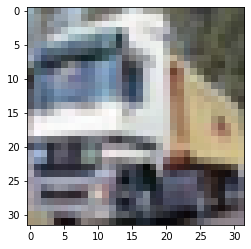

In [14]:
sample_img = next(iter(train_loader))[0]
sample_img = sample_img.permute(0,2,3,1).numpy()
plt.imshow(sample_img[1])

In [15]:
cnn_net.eval()

model_cnn(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=1152, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [16]:
sample_img = sample_img.to(device)

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [ ]:
output = cnn_net.forward(sample_img)

In [ ]:
output = F.softmax(output)

In [ ]:
output = output.cpu().detach().numpy()